In [21]:
library(repr) ; options(repr.plot.res = 100, repr.plot.width = 5, repr.plot.height = 5) # Change plot sizes (in cm) - this bit of code is only relevant if you are using a jupyter notebook - ignore otherwise

# Linear Models: Multiple explanatory variables

## Introduction

In this chapter we will explore fitting a linear model to data when you have multiple explanatory (predictor) variables. 

The aims of this chapter are[$^{[1]}$](#fn1):

* Learning to build and fit a linear model that includes several explanatory variables

* Learning to interpret the summary tables and diagnostics after fitting a linear model with multiple explanatory variables

## An example

The models we looked at in the [ANOVA chapter](15-anova.ipynb) explored whether the log genome size (C value, in picograms) of terrestrial mammals varied with trophic level and whether or not the species is ground dwelling. We will now look at a single model that includes both explanatory variables.

The first thing to do is look at the data again. 

### Exploring the data

$\star$ Create a new blank script called `MulExpl.R` in your `Code` directory and add some introductory comments.

$\star$ Load the data saved at the end of the [ANOVA chapter](15-anova.ipynb):

In [3]:
load('../data/mammals.Rdata')

Look back at the end of the previous chapter to see how you saved the RData file. If `mammals.Rdata` is missing, just import the data again using `read.csv` and add the `log C Value` column to the imported data frame again (go back to the [ANOVA chapter](15-anova.ipynb) and have a look if you have forgotten how).

Use `ls()`, and then `str` to check that the data has loaded correctly:

In [4]:
str(mammals)

'data.frame':	379 obs. of  10 variables:
 $ Binomial       : Factor w/ 379 levels "Acinonyx jubatus",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ meanCvalue     : num  2.56 2.64 3.75 3.7 3.98 4.69 2.15 2.43 2.73 2.92 ...
 $ Order          : Factor w/ 21 levels "Artiodactyla",..: 2 17 17 17 1 1 4 17 17 17 ...
 $ AdultBodyMass_g: num  50500 41.2 130 96.5 94700 52300 15 25.3 50.5 33 ...
 $ DietBreadth    : int  1 NA 2 NA 5 2 NA 4 NA NA ...
 $ HabitatBreadth : int  1 NA 2 2 1 1 1 2 NA 1 ...
 $ LitterSize     : num  2.99 2.43 3.07 NA 1 1 0.99 4.59 3.9 3.77 ...
 $ GroundDwelling : Factor w/ 2 levels "No","Yes": 2 NA 2 2 2 2 1 2 NA 2 ...
 $ TrophicLevel   : Factor w/ 3 levels "Carnivore","Herbivore",..: 1 NA 2 NA 2 2 NA 3 NA NA ...
 $ logCvalue      : num  0.94 0.971 1.322 1.308 1.381 ...


[Previously](14-regress.ipynb), we asked if carnivores or herbivores had larger genomes. Now we want to ask questions like: do ground-dwelling carnivores have larger genomes than arboreal or flying omnivores? We need to look at plots within groups.

Before we do that, there is a lot of missing data in the data frame and we should make sure that we are using the same data for our plots and models. We will subset the data down to the complete data for the three variables:

In [5]:
mammals <- subset(mammals, select = c(GroundDwelling, TrophicLevel, 
logCvalue))
mammals <- na.omit(mammals)
str(mammals)

'data.frame':	259 obs. of  3 variables:
 $ GroundDwelling: Factor w/ 2 levels "No","Yes": 2 2 2 2 2 1 2 1 1 1 ...
 $ TrophicLevel  : Factor w/ 3 levels "Carnivore","Herbivore",..: 1 2 2 2 3 3 3 2 2 3 ...
 $ logCvalue     : num  0.94 1.322 1.381 1.545 0.888 ...
 - attr(*, "na.action")=Class 'omit'  Named int [1:120] 2 4 7 9 10 11 14 15 20 21 ...
  .. ..- attr(*, "names")= chr [1:120] "2" "4" "7" "9" ...


### Boxplots within groups

[Previously](14-regress.ipynb), we used the `subset` option to fit a model just to dragonflies. You can use `subset` with plots too.

$\star$ Add `par(mfrow=c(1,2))` to your script to split the graphics into two panels.

$\star$ Copy over and modify the code from the [ANOVA chapter](15-anova.ipynb) to create a boxplot of genome size by trophic level into your script.

$\star$ Now further modify the code to generate the plots shown in the figure below (you will have to `subset` your data for this, and also use the subset option of the `plot` command): 

![image](./graphics/boxplots.svg)
<small> <center> Figure 1
</center> </small>

You can use the option `main` to add titles to a plot.


### `lattice` again

Recall that the `lattice` package provides some very neat extra ways to plot data in groups. They look pretty but the downside is that they don't use the same graphics system — all those `par` commands are useless for these graphs. The defaults look good though!

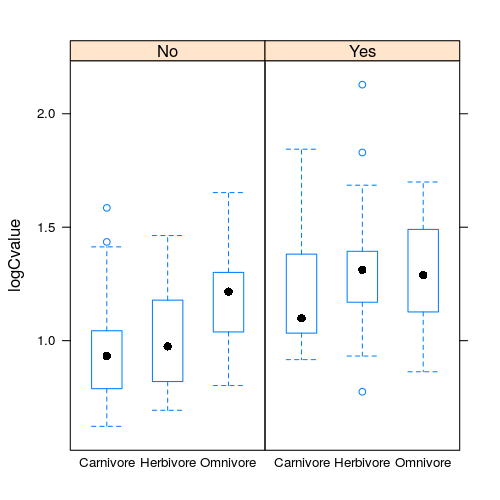

In [6]:
library(lattice)
bwplot(logCvalue ~ TrophicLevel | GroundDwelling, data= mammals)

The code `logCvalue ~ TrophicLevel | GroundDwelling` means plot the relationship between genome size and trophic level, but group within levels of ground dwelling. We are using the function `bwplot`, which is provided by `lattice` to create box and whisker plots.

$\star$ Create the lattice plots above from within your script.

Rearrange this code to have three plots, showing the box and whisker plots for `GroundDwelling`, grouped within the levels of `TrophicLevel`.

Try reshaping the R plot window and running the command again. Lattice tries to make good use of the available space when creating lattice plots.

### Barplots again

We're going to make the barplot code from [Regress](14-regress.ipynb) even more complicated! This time we want to know the mean log genome size within combinations of `TrophicLevel` and `GroundDwelling`. We can still use `tapply`, providing more than one grouping factor. We create a set of grouping factors like this:

In [7]:
groups <- list(mammals$GroundDwelling, mammals$TrophicLevel)
groupMeans <- tapply(mammals$logCvalue, groups, FUN = mean)
print(groupMeans)

    Carnivore Herbivore Omnivore
No  0.9589465  1.012459 1.191760
Yes 1.2138170  1.297662 1.299017


$\star$ Copy this code into your script and run it.

Use this code and the script from the [ANOVA chapter](15-anova.ipynb) to get the set of
standard errors for the groups `groupSE`:

In [8]:
seMean <- function(x){
	# get rid of missing values
	x <- na.omit(x)
	# calculate the standard error
	se <- sqrt(var(x)/length(x))
	# tell the function to report the standard error
	return(se)
}

In [9]:
groups <- list(mammals$GroundDwelling, mammals$TrophicLevel)

groupMeans <- tapply(mammals$logCvalue, groups, FUN=mean)
print(groupMeans)

    Carnivore Herbivore Omnivore
No  0.9589465  1.012459 1.191760
Yes 1.2138170  1.297662 1.299017


In [10]:
groupSE <- tapply(mammals$logCvalue, groups, FUN=seMean)
print(groupSE)

     Carnivore  Herbivore   Omnivore
No  0.04842209 0.03418613 0.02410400
Yes 0.05975510 0.02787009 0.03586826


Now we can use `barplot`. The default option for a barplot of
a table is to create a stacked barplot, which is not what we want. The
option `beside=TRUE` makes the bars for each column appear
side by side.

Once again, we save the midpoints of the bars to add the
error bars. The other options in the code below change the colours of
the bars and the length of error bar caps.

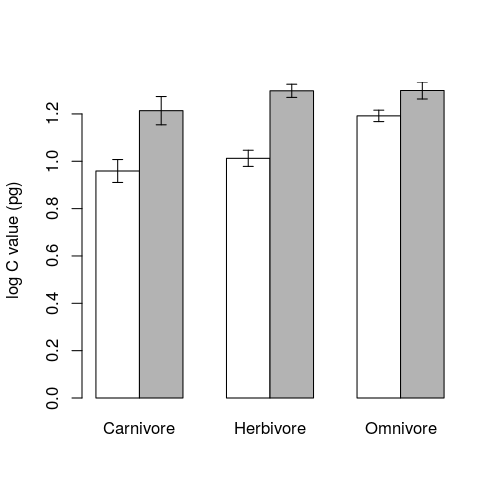

In [11]:
# get upper and lower standard error height
upperSE <- groupMeans + groupSE
lowerSE <- groupMeans - groupSE
# create barplot
barMids <- barplot(groupMeans, ylim=c(0, max(upperSE)), beside=TRUE, ylab= ' log C value (pg) ' , col=c( ' white ' , ' grey70 '))
arrows(barMids, upperSE, barMids, lowerSE, ang=90, code=3, len=0.05)

$\star$ Generate the barplot above and then edit your script to change the colours and error bar lengths to your taste.

### Plotting means and confidence intervals

We'll use the `plotmeans` function again as an exercise to change graph settings and to prepare figures for reports and write ups. This is the figure you should be able to reproduce:

![image](./graphics/plotmeans.svg)
<small> <center> Means and 95% confidence intervals for log genome size (picograms) in mammals for different trophic levels for a) ground dwelling species and b) other species. </center> </small>

$\star$ Use `plotmeans` from the [ANOVA chapter](15-anova.ipynb) and the `subset` option to generate the two plots below. You will need to
set the `ylim` option for the two plots to make them use the same $y$ axis.

$\star$ Use `text` to add labels — the command `par('usr')` will show you the limits of the plot ($x_{min}, x_{max}, y_{min}, y_{max}$) and help pick a location for the labels.

$\star$ Change the `par` settings in your code and redraw the plots to try and make better use of the space. In the example below, the box shows the edges of the R graphics window.

Note the following about the this figure ([Figure xx](#fig:plotmeans)): 

* **White space**: The default options in R use wide margins and spaced out axes and take up a lot of space that could be used for plotting data. You've already seen the `par` function and the options `mfrow` for multiple plots and `mar` to adjust margin size. The option `mgp` adjusts the placement of the axis label, tick labels and tick locations. See `?par` for help on the these options.

* **Main titles**: Adding large titles to graphs is also a bad idea — it uses lots of space to explain something that should be in the figure legend. With multiple plots in a figure, you have to label graphs so that the figure legend can refer to them. You can add labels using `text(x,y,'label')`.

* **Figure legends**: A figure caption and legend should give a clear stand-alone description of the whole figure.

* **Referring to figures**: You *must* link from your text to your figures — a reader has to know which figures refer to which results. So: 'There are clear differences in mean genome size between species at different trophic levels and between ground dwelling and other species, [Figure xx](#fig:plotmeans)'.


## Fitting the linear model

All those exploratory visualizations suggest:

* Carnivores have smaller genome size; omnivores have larger genome size.

* Herbivores are somewhere in between, but not consistently.

* All ground dwelling mammals typically have larger genome sizes.

We suspected these things from the [ANOVA chapter analyses](15-anova.ipynb), but now we can see that they might have separate effects. We'll fit a linear model to explore this and add the two explanatory variables together.

$\star$ This is an important section — read it through carefully and ask questions if you are unsure. Copy the code into your script and add comments. *Do not just jump to the next action item*!

$\star$ First, fit the model:

In [12]:
model <- lm(logCvalue ~ TrophicLevel + GroundDwelling, data = mammals)    

We're going to do things right this time and check the model diagnostics
before we rush into interpretation.

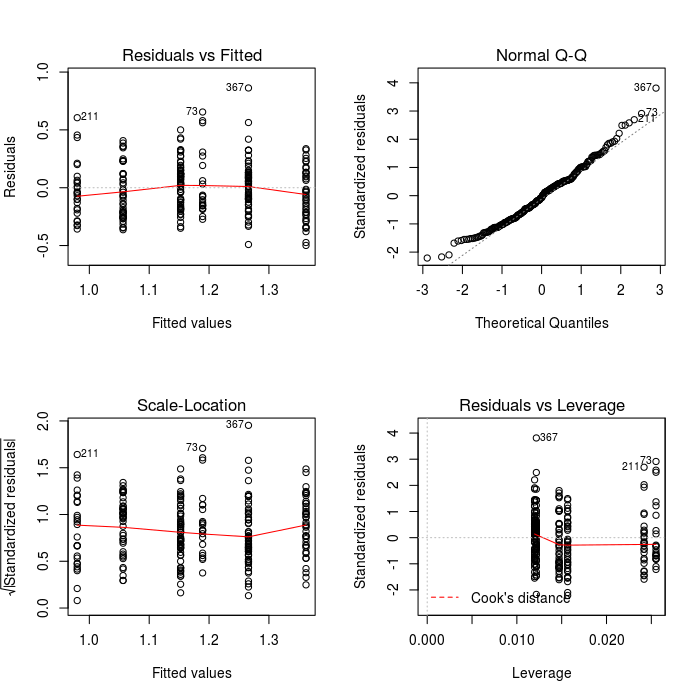

In [22]:
par(mfrow=c(2,2))
plot(model)

Examine these diagnostic plots. There are six predicted values now - three trophic levels for each of the two levels of ground dwelling. Those plots look ok so now we can look at the analysis of variance table:

In [14]:
anova(model)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
TrophicLevel,2,0.8141063,0.40705316,7.859815,4.870855e-04
GroundDwelling,1,2.7469218,2.74692183,53.040485,4.062981e-12
Residuals,255,13.2062341,0.05178915,NA,NA


*Ignore the $p$ values*! Yes, they're highly significant but we want to understand the model, not rubber stamp it with 'significant'.

The sums of squares for the variables are both small compared to the residual sums of squares — there is lots of unexplained variation. We can calculate the $r^2$ as explained sums of squares over total sums of squares:

$$\frac{0.81 + 2.75}{0.81 + 2.75 + 13.21} = \frac{3.56}{16.77} = 0.212$$

Trophic level explain much less variation than ground dwelling — this makes intuitive sense from the plots since there are big differences between in the [figure we generated](#fig:plotmeans) (a vs b), but small differences within.

We could also calculate a significance for the whole model by merging the terms. The total explained sums of squares of $0.81 + 2.75  = 3.56$ uses $2+1 =3$ degrees of freedom, so the mean sums of squares for all the terms together is $3.56/3=1.187$. Dividing this by the residual mean square of 0.052 gives an F of $1.187 / 0.052 = 22.83$.

Now we can look at the summary table to see the coefficients:

In [15]:
summary(model) 


Call:
lm(formula = logCvalue ~ TrophicLevel + GroundDwelling, data = mammals)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.49902 -0.17844 -0.01462  0.12496  0.86242 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.97976    0.03539  27.682  < 2e-16 ***
TrophicLevelHerbivore  0.07659    0.03969   1.930   0.0547 .  
TrophicLevelOmnivore   0.17269    0.03977   4.343 2.03e-05 ***
GroundDwellingYes      0.20947    0.02876   7.283 4.06e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2276 on 255 degrees of freedom
Multiple R-squared:  0.2124,	Adjusted R-squared:  0.2031 
F-statistic: 22.92 on 3 and 255 DF,  p-value: 3.602e-13


Starting at the bottom of this output, `summary` has again calculated $r^2$ for us and also an $F$ statistic for the whole model, which matches the calculation above.

The other important bits are the four coefficients. The intercept is now the reference level for two variables: it is the mean for carnivores that are not ground dwelling. We then have differences from this value for being an omnivore or herbivore and for being ground dwelling. There is a big change in genome size associated with ground dwelling and
omnivory and both of these have large effects sizes, each introducing about a 20% difference in genome size from the non-ground dwelling carnivores. In contrast, herbivory makes a small difference — about 8%. 

Because the difference is small and the standard error is large, the $t$ value suggests that this difference might arise just be chance. Put another way, it isn't significant.

The table below shows how these four coefficients combine to give the predicted values for each of the group means.

$\begin{array}{|r|rrr|}
\hline
         & \textrm{Carnivore} & \textrm{Herbivore} & \textrm{Omnivore}\\
\hline
\textrm{Not ground} & {\it 0.98} = 0.98    & {\it 0.98  + 0.08} =1.06    & {\it 0.98 + 0.17} =1.15 \\
\textrm{Ground}     & {\it 0.98 + 0.21} = 1.19    & {\it 0.98  + 0.08   + 0.21} =1.27   & {\it 0.98 + 0.17  + 0.21} =1.36\\
\hline
\end{array}$

### Predicted values

Getting the model predictions by hand in this way is tedious and error prone. There is a handy function called `predict` which uses the model directly to calculate values. The default is to give you the prediction for each point in the original data, but you can also ask for specific predictions.

The first thing to do is to set up a small data frame containing the explanatory values we want to use. The variable names and the level name have to match *exactly*, so we'll use the `levels` function to get the names. We want to look at all six combinations, so we'll use the `rep` function to set this up. The `each = 2` option repeats each value twice in succession; the `times = 3` options repeats the whole set of values three times.

Let's do it:

In [16]:
# data frame of combinations of variables
gd <- rep(levels(mammals$GroundDwelling), times = 3)
print(gd)

[1] "No"  "Yes" "No"  "Yes" "No"  "Yes"


In [17]:
tl <- rep(levels(mammals$TrophicLevel), each = 2)
print(tl)

[1] "Carnivore" "Carnivore" "Herbivore" "Herbivore" "Omnivore"  "Omnivore" 


In [18]:
predVals <- data.frame(GroundDwelling = gd, TrophicLevel = tl)

Now we have the data frame of values we want, we can use `predict`. Just as when we created log values, we can save the output back into a new column in the data frame:

In [19]:
predVals$predict <- predict(model, newdata = predVals)
print(predVals)

  GroundDwelling TrophicLevel   predict
1             No    Carnivore 0.9797572
2            Yes    Carnivore 1.1892226
3             No    Herbivore 1.0563447
4            Yes    Herbivore 1.2658102
5             No     Omnivore 1.1524491
6            Yes     Omnivore 1.3619145


Not that these are in the same order as the bars from your barplot. 

$\star$ Make a copy of the barplot and arrows code from above and modify it

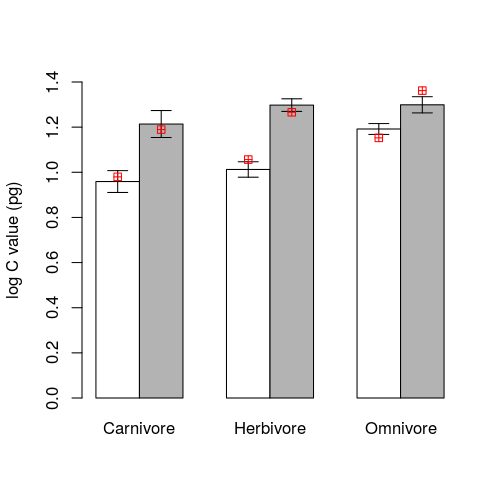

In [20]:
barMids <- barplot(groupMeans, ylim=c(0, 1.4), ylab='log C value (pg)', beside=TRUE, col=c('white', 'grey70'))

arrows(barMids, upperSE, barMids, lowerSE, ang=90, code=3, len=0.1)
points(barMids, predVals$predict, col='red', pch=12)

The red markers do not match to the calculated means. This is because the model only includes a single difference between ground and non-ground species, which has to be the same for each trophic group. That is, there is no interaction between trophic level and ground / non-ground identity of each species in the current model.

$\star$ Add the code for this plot to your script file.

[Next](17-MulExplInter.ipynb), we will look at interactions, which allows these values to differ using an interaction term in the model.

---
<a id="fn1"></a>
[1]: Here you work with the script file `MulExpl.R`